## SelfDrivingCar-P4-Advanced_LaneLines
Udacity CarND Project 4

Advanced Lane Finding
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.

The Project
The goals / steps of this project are the following:

+ Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
+ Apply a distortion correction to raw images.
+ Use color transforms, gradients, etc., to create a thresholded binary image.
+ Apply a perspective transform to rectify binary image ("birds-eye view").
+ Detect lane pixels and fit to find the lane boundary.
+ Determine the curvature of the lane and vehicle position with respect to center.
+ Warp the detected lane boundaries back onto the original image.
+ Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# 1. Camera Calibration

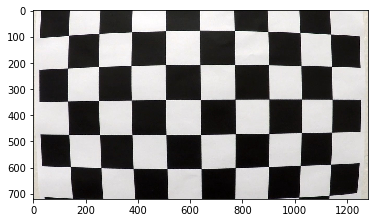

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import cv2

# Read and check the data
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)


# 2. Distrotion Correction

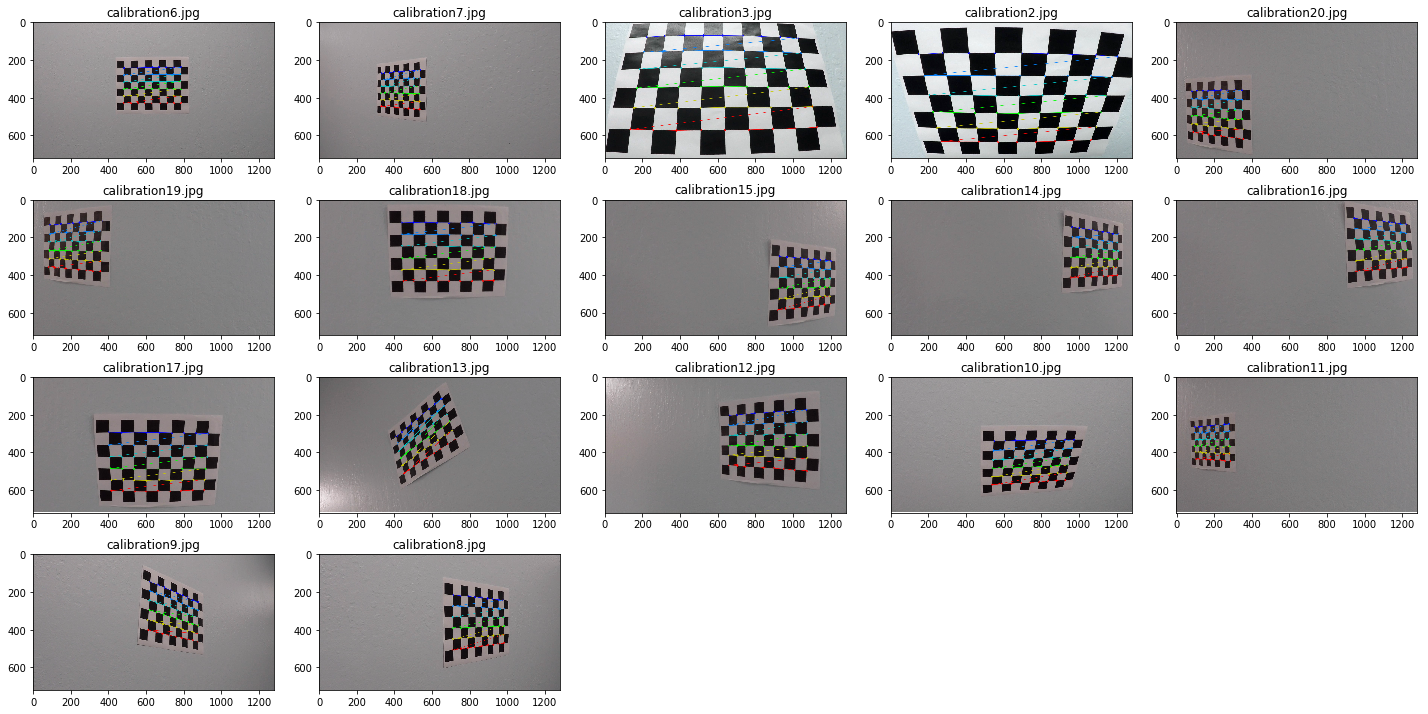

In [2]:
# Find corners
import glob #glob API
images = glob.glob('./camera_cal/calibration*.jpg')

nx, ny = 9, 6
objpoints = [] # 3D points in the real world (x,y,z) from top left to bottom right
imgpoints = [] # 2D points 

# Prepare object points
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

count = 1
plt.figure(figsize = (20,10))
for fname in images: # not all fname will have corners
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # draw detected corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(4, 5, count)
        plt.imshow(img)
        plt.title(fname.split('/')[-1])
        count = count+1
plt.tight_layout()
plt.show()


calibration result saved!
(720, 1280, 3)


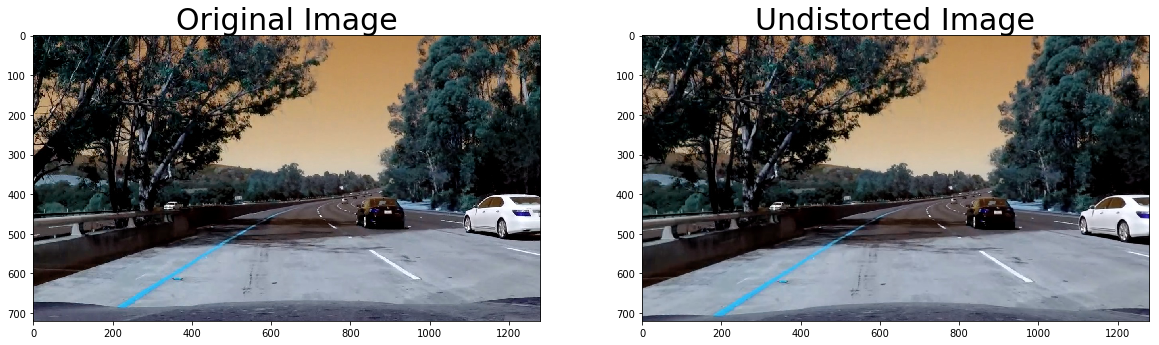

In [3]:
# Test undistortion on an image
img = cv2.imread('./test_images/test5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

np.savez('calibration.npz',mtx=mtx,dist=dist)
print('calibration result saved!')

f = np.load('calibration.npz')
mtx = f['mtx']
dist = f['dist']
undist_img = cv2.undistort(img, mtx, dist)
cv2.imwrite('./output_images/test5.jpg',undist_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

print(undist_img.shape)

(720, 1280, 3)


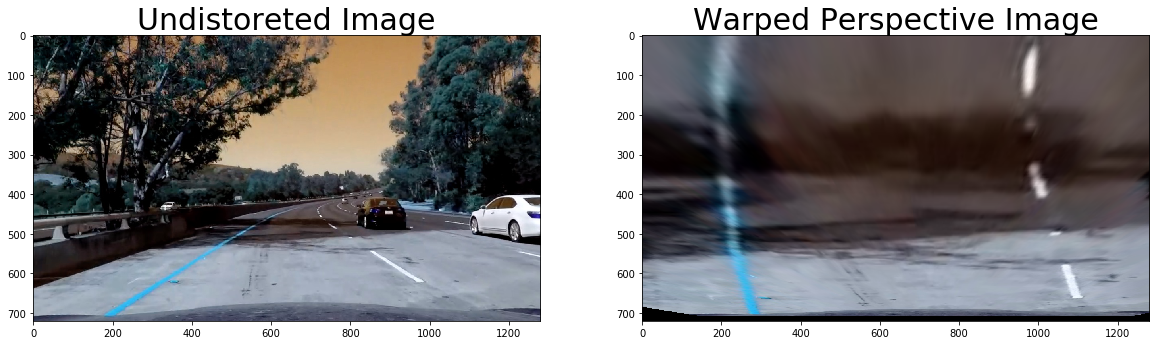

In [4]:
# Define and Test perspective-view
def perspectiveview(img,src,dst):
    #src = np.float32([[400,600],[1000,600],[750,450],[600,450]])
    img_size = img.shape[:2][::-1]
    offset = 200
    #dst = np.float32([[offset,img_size[1]-offset],[img_size[0]-offset,img_size[1]-offset],[img_size[0]-offset,offset],[offset,offset]])
    #dst = np.float32([[400,700],[1000,700],[1000,0],[400,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

src = np.float32([[400,600],[1000,600],[750,450],[600,450]])
dst = np.float32([[400,700],[1000,700],[1000,0],[400,0]])


src = np.float32([[0,700],[600,450],[750,450],[1200,700]])
dst = np.float32([[100,700],[100,0],[1200,0],[1200,700]])
warped_img, M = perspectiveview(undist_img,src,dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_img)
ax1.set_title('Undistoreted Image', fontsize=30)
ax2.imshow(warped_img)
ax2.set_title('Warped Perspective Image', fontsize=30)
print(warped_img.shape)

# 3. Color & Gradient Threshold

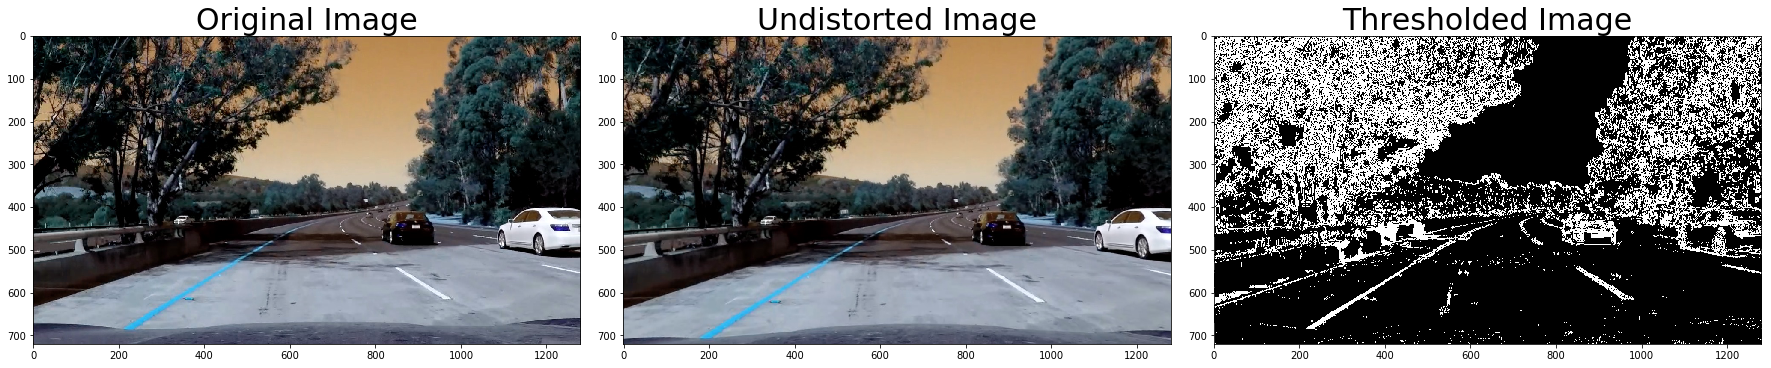

In [5]:
# Define threshold function
def sobel(image,sobel_kernel=3):
    # Calculate directional gradient
    # Apply threshold
    if len(image.shape)>2:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1)
    return sobelx,sobely

def abs_sobel_thresh(sobel,thresh=(0,255)):
    # Apply threshold
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scale_sobel)
    grad_binary[(scale_sobel>=thresh[0])&(scale_sobel<=thresh[1])]=1
    return grad_binary

def mag_thresh(sobelx,sobely,mag_thresh=(0,255)):
    # Apply threshold
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_sobel = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag>=mag_thresh[0])&(mag<=mag_thresh[1])]=1
    return mag_binary


def dir_threshold(sobelx,sobely,dir_thresh=(0,np.pi/2)):
    # Apply threshold
    angle = np.arctan2(sobely,sobelx)
    dir_binary = np.zeros_like(angle)
    dir_binary[(angle>=dir_thresh[0])&(angle<=dir_thresh[1])]=1
    return dir_binary

def s_threshold(image,s_thresh = (0,255)): #color_threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary


def combined_threshold(image,ksize=3,gradthresh=(0,255),magthresh=(0,255),dirthresh=(0,np.pi/2),sthresh=(0,255)):
    # Calculate sobelx and sobely
    sobelx,sobely = sobel(image,sobel_kernel=ksize)
    
    gradx = abs_sobel_thresh(sobelx,thresh=gradthresh)
    grady = abs_sobel_thresh(sobely,thresh=gradthresh)
    mag_binary = mag_thresh(sobelx,sobely,mag_thresh=magthresh)
    dir_binary = dir_threshold(sobelx,sobely,dir_thresh=dirthresh)
    s_binary = s_threshold(image,s_thresh=sthresh)

    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary == 1)|(gradx == 1) ] = 1
    
    
    return combined_binary


#img = mpimg.imread('signs_vehicles_xygrad.png')
#img = mpimg.imread('./test_images/test5.jpg')
undist_img = cv2.undistort(img, mtx, dist)

combined = combined_threshold(undist_img,gradthresh=(10,100),magthresh=(20,100),sthresh=(170,255),dirthresh=(0.7,1.3))
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 4. Perspective Transform

Text(0.5,1,'Warped Perspective Image')

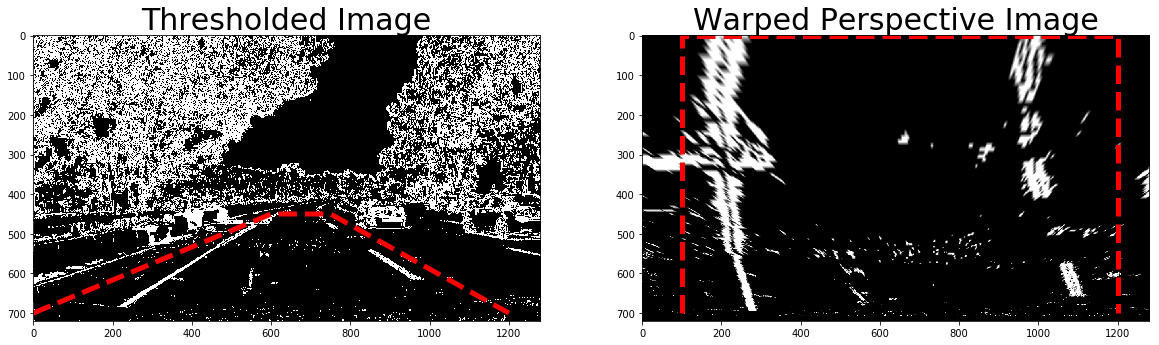

In [6]:

src = np.float32([[0,700],[600,450],[750,450],[1200,700]])
dst = np.float32([[100,700],[100,0],[1200,0],[1200,700]])

warped_img, M = perspectiveview(combined,src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined,cmap='gray')
ax1.plot(src[:,0],src[:,1],'r--',linewidth=5)
ax1.set_title('Thresholded Image', fontsize=30)
ax2.imshow(warped_img,cmap='gray')
ax2.plot(dst[:,0],dst[:,1],'r--',linewidth=5)
ax2.set_title('Warped Perspective Image', fontsize=30)



# 5. Detect Lane Lines

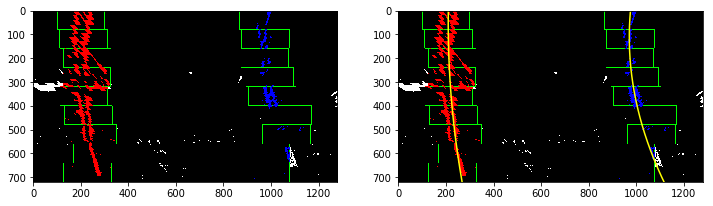

In [7]:
# Finding the Line # Method 1-fit a polynominal Sec 33

import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = np.uint8(warped_img)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
histogram = np.sum(binary_warped[0:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f,[ax1,ax2]=plt.subplots(1,2,figsize = (12,8))

ax1.imshow(out_img)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

np.savez('out_img.npz',out_img)


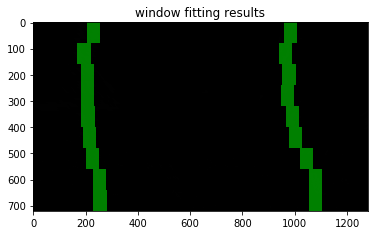

In [8]:
# Sliding window search # Method 2- Convolution Sec 34
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = warped_img
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [12]:
# Create an image to draw the lines on
def map_back(image,wraped,left_fixx,ploty,right_fitx,Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result
result = map_back(img,warped,left_fixx,right_fitx,Minv)
plt.imshow(result)


NameError: name 'left_fixx' is not defined